In [ ]:
!pip install git+https://github.com/qubvel/efficientnet

In [ ]:
# %tensorflow_version 2.3.0
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from efficientnet.keras import EfficientNetB0 as ENetB0
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi


2.2.0


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip "/content/gdrive/My Drive/Project/train.zip" -d "./"

In [ ]:
!unzip "/content/gdrive/My Drive/Project/test.zip" -d "./"

In [ ]:
trainDF = pd.read_csv("/content/gdrive/My Drive/Project/train.txt", sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv("/content/gdrive/My Drive/Project/test.txt", sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
trainData = trainDF.shape[0] * 0.75
valData = trainDF.shape[0] * 0.25
# print(trainData, valData)

test_datagen = ImageDataGenerator(rescale=1./255)

BatchSize = 98

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/content/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=BatchSize,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(100,200))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/content/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=BatchSize,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(100,200))


Found 27342 validated image filenames.
Found 9113 validated image filenames.


In [ ]:
def ENetB0_FE(width, height, depth):

    conv_base = ENetB0(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


16809984/16804768 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 7, 1280)        4049564   
_________________________________________________________________
flatten_1 (Flatten)          (None, 35840)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1164)              41718924  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1164)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               116500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_______________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/10
279/279 [==============================] - 127s 455ms/step - loss: 0.4740 - val_loss: 0.2409

Epoch 00002: saving model to /content/gdrive/My Drive/Project/ENetB0/ENetB0_FE/ENetB0_FE_weights.02-0.24.h5
Epoch 3/10
279/279 [==============================] - 126s 450ms/step - loss: 0.4465 - val_loss: 0.2395

Epoch 00003: saving model to /content/gdrive/My Drive/Project/ENetB0/ENetB0_FE/ENetB0_FE_weights.03-0.24.h5
Epoch 4/10
279/279 [==============================] - 127s 454ms/step - loss: 0.4304 - val_loss: 0.2390

Epoch 00004: saving model to /content/gdrive/My Drive/Project/ENetB0/ENetB0_FE/ENetB0_FE_weights.04-0.24.h5
Epoch 5/10
279/279 [==============================] - 127s 454ms/step - loss: 0.4182 - val_loss: 0.2389

Epoch 00005: saving model to /content/gdrive/My Drive/Project/ENetB0/ENetB0_FE/ENetB0_FE_weights.05-0.24.h5
Epoch 6/10
279/279 [==============================] - 127s 454ms/step - loss: 0.4027 - val_loss: 0.2389

Epoch 00006: saving model to /content/gdriv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


avg_train_loss: 0.4188407832522973
avg_val_loss: 0.23905572444200515
difference: 0.17978505881029214


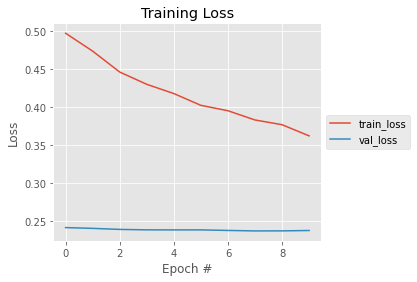

In [ ]:
from keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 10

model = ENetB0_FE(width=200, height=100, depth=3)
print (model.summary())

model.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1e-4), loss="mse")

filepath = "/content/gdrive/My Drive/Project/ENetB0/ENetB0_FE/ENetB0_FE_weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1)

history = model.fit(
                train_generator,
                steps_per_epoch=round(trainData/BatchSize),
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=round(valData/BatchSize),
                callbacks=[checkpoint])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

avg_train_loss = sum(history.history["loss"])/NUM_EPOCHS
avg_val_loss = sum(history.history["val_loss"])/NUM_EPOCHS

print("avg_train_loss: " + str(avg_train_loss))
print("avg_val_loss: " + str(avg_val_loss))
print("difference: " + str(abs(avg_train_loss - avg_val_loss)))


In [ ]:
from keras.models import load_model

test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/content/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(100,200))

filepath = "/content/gdrive/My Drive/Project/ENetB0/ENetB0_FE/ENetB0_FE_weights.10-0.24.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)
print('Predictions: ', predictions.shape)

Found 8951 validated image filenames.
Predictions:  (8951, 1)


In [ ]:
import pandas as pd

Images = testDF['Images']
preds = predictions
actual = testDF['SteeringAngle']

df_preds = pd.DataFrame(Images)
df_preds['Actual Steering Angle'] = (actual * (pi / 180))
df_preds['Predicted Steering Angle'] = preds
df_preds.rename(columns = {0:'Images'}, inplace = True) 

df_preds['MAE'] = 0

for i in range(len(df_preds)):
  df_preds.iloc[i, -1] = abs(df_preds.iloc[i, 1] - df_preds.iloc[i, 2])

mae_sum = 0
for i in range(len(df_preds)):
    mae_sum += df_preds.iloc[i, -1]
    
print("mae_sum: " + str(mae_sum))    
MAE = mae_sum / len(df_preds)
print("len(df_preds): " + str(len(df_preds)))
print("MAE: " + str(MAE))

mae_sum: 2392.5704318157427
len(df_preds): 8951
MAE: 0.26729643970681966


In [ ]:
df_preds[8900:]

,Images,Actual Steering Angle,Predicted Steering Angle,MAE
8900,45356.jpg,0.100356,0.102794,0.002438
8901,45357.jpg,0.093201,0.365377,0.272176
8902,45358.jpg,0.089710,0.178326,0.088616
8903,45359.jpg,0.086219,0.181993,0.095774
8904,45360.jpg,0.080983,0.148175,0.067191
8905,45361.jpg,0.074002,-0.214174,0.288176
8906,45362.jpg,0.074002,0.029196,0.044806
8907,45363.jpg,0.066846,0.168766,0.101920
8908,45364.jpg,0.063355,-0.092558,0.155913
8909,45365.jpg,0.054629,0.169996,0.115367
